# SAYCam autocorrelation analysis



Chris Iyer

updated 12/11/24

In [ ]:
import os, glob, cv2
import numpy as np
import matplotlib.pyplot as plt

from utils import pickle_save_dict, pickle_load_dict, compute_stats 
from video_processing import load_model, read_embed_video, plot_frames, get_cropping_dims
from autocorrelation import concatenate_embeddings_timestamps, get_consec_dists, run_plot_acf, get_familiarity_timeseries 
# these ^^^ are the important fxns! 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
INPUT_DIR = 'videos'
OUTPUT_DIR = 'outputs'

DOWNSAMPLED_FR = 3
MODEL_NAME = 'vit' # 'vit' or 'resnet' # respectively, these will make 768-D or 2048-D embeddings
DEVICE = 'cpu' # 'cpu' or 'cuda'
N_JOBS = 4
PERMUTE_N_ITER = 0

In [ ]:
# DELETE THIS -- for converting existing embeddings to pickle
from datetime import datetime, timedelta

embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*{MODEL_NAME}*.pkl'))
all_embeddings = [pickle_load_dict(e)['embeddings'] for e in embeddings_paths]

save_folder = os.path.join(OUTPUT_DIR, 'video_embeddings')
downsampled_frame_rate = DOWNSAMPLED_FR

for video_folder_path, ALL_OUTPUT_FRAMES in zip(embeddings_paths, all_embeddings):

    filename_only = video_folder_path[video_folder_path.rfind('/')+1:]
    start_idx = len(video_folder_path) - len(filename_only) + filename_only.find('_') # right after the first underscore (after last /) comes the date YYYYMMDD_HHMM
    video_start_time = datetime.strptime(video_folder_path[start_idx+1:start_idx+14], "%Y%m%d_%H%M")

    datetime_array = [video_start_time + timedelta(seconds=i / downsampled_frame_rate) for i in range(len(ALL_OUTPUT_FRAMES))]
    timestamp_array = np.array([datetime.strftime(t, "%Y%m%d_%H%M_%S.%f")[:-4] for t in datetime_array])

    output_dict = {'embeddings': ALL_OUTPUT_FRAMES, 'timestamps': timestamp_array}
    save_path = os.path.join(save_folder, video_folder_path.split('/')[-1][:-8]) + f'-{MODEL_NAME}.pkl'
    pickle_save_dict(output_dict, save_path)

## View example frames

CROPPING INFORMATION:

Each video is cropped with a square crop of side length 420 pixels, centered 30 pixels below center.

100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


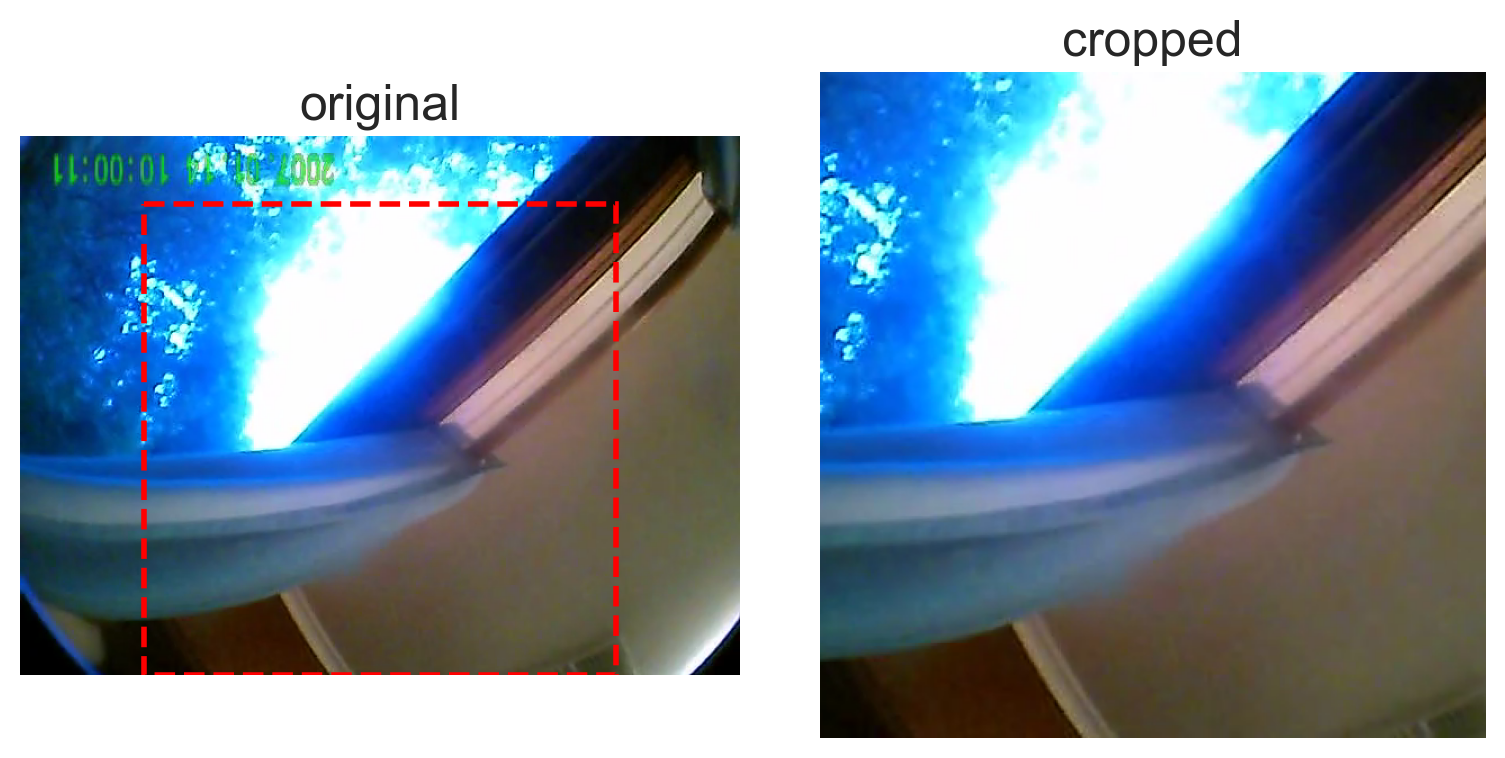

100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


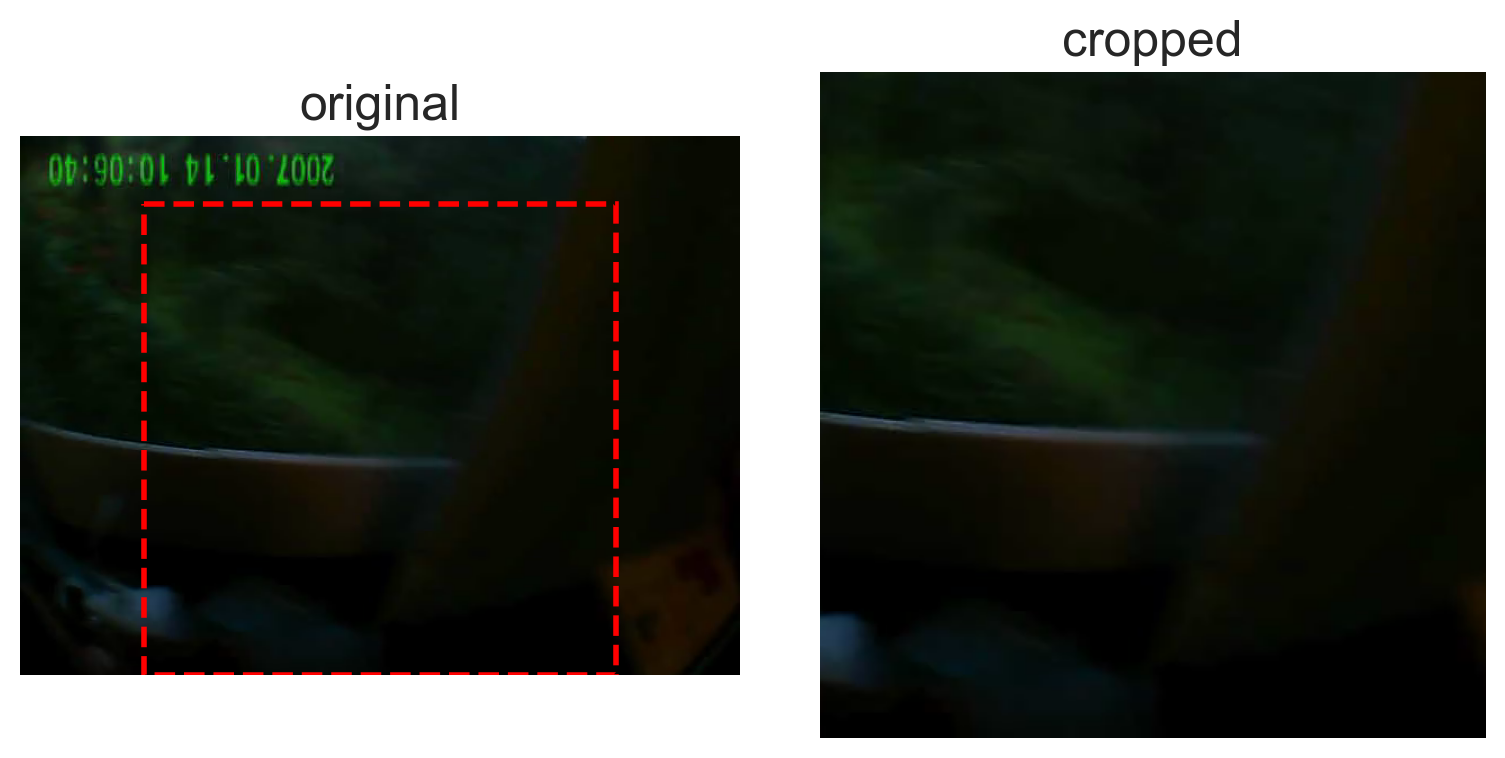

100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


In [ ]:
# See example frames (second frame of each video) and the different preprocessing steps
video_paths = sorted(glob.glob(INPUT_DIR + '/**/*.mp4'))

frame_num = 10
for video in video_paths[:min(len(video_paths), 5)]:
    
    frame1 = read_embed_video(video, n_frames=frame_num, preprocess=False)[0][frame_num-1] # gets the second frame
    frame2 = read_embed_video(video, n_frames=frame_num, preprocess=True)[0][frame_num-1]

    cap =  cv2.VideoCapture(video)
    crop_dims = get_cropping_dims(cap)
    cap.release()
    
    plot_frames([cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)[::-1,::-1,:] , frame2], ['original', 'cropped'], 
                crop_dims=crop_dims)

## Model embedding 

Google vision transformer https://huggingface.co/docs/transformers/en/model_doc/vit

Resnet: https://huggingface.co/docs/transformers/en/model_doc/resnet

In [ ]:
save_folder = os.path.join(OUTPUT_DIR, 'video_embeddings')

for i,subfolder in enumerate(os.listdir(INPUT_DIR)):
    subfolder_path = os.path.join(INPUT_DIR, subfolder)

    # each subfolder corresponds to one "video" with multiple video files within to be concatenated
    if os.path.isdir(subfolder_path):
        print(f'Beginning video {i+1} out of {len(os.listdir(INPUT_DIR))}')

        embeddings, timestamps = read_embed_video(subfolder_path, 
                                      n_frames=None, 
                                      downsampled_frame_rate=DOWNSAMPLED_FR, 
                                      preprocess=True, 
                                      model_name=MODEL_NAME, 
                                      save_folder=save_folder, 
                                      n_jobs=N_JOBS, 
                                      device=DEVICE)
        
        if save_folder:
            print(f'Saved results to {save_folder}, shape: {embeddings.shape}')
    
# code for saving an entire array with pkl instead:
# pickle_save_dict(embedding_list, outpath)

In [ ]:
# how much larger are the videos compared to embeddings?
for model in ['vit', 'resnet']:
    e_to_v_ratios = []
    
    for subfolder in os.listdir(INPUT_DIR):
        embedding_size = os.path.getsize(os.path.join(OUTPUT_DIR, 'video_embeddings', f'{subfolder}-{model}.pkl'))
        sum_vpath_sizes = sum([e.stat().st_size for e in os.scandir(os.path.join(INPUT_DIR, subfolder))])
        e_to_v_ratios.append(embedding_size/sum_vpath_sizes)

    print(f'{model} average embedding-to-video ratio: {np.round(np.mean(e_to_v_ratios), 3)}')

vit average embedding-to-video ratio: 0.029
resnet average embedding-to-video ratio: 0.077


## Raw autocorrelation

In [ ]:
# Load embeddings if not already loaded
embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*{MODEL_NAME}*.pkl'))
all_dicts = [pickle_load_dict(e) for e in embeddings_paths]
all_embeddings, _ = concatenate_embeddings_timestamps([d['embeddings'] for d in all_dicts], 
                                                      [d['timestamps'] for d in all_dicts],
                                                      downsampled_frame_rate=DOWNSAMPLED_FR)


first, we want to look for a power law decay in the autocorrelation function over time (not looking at gap or threshold)

Computing autocorrelation of raw embeddings...


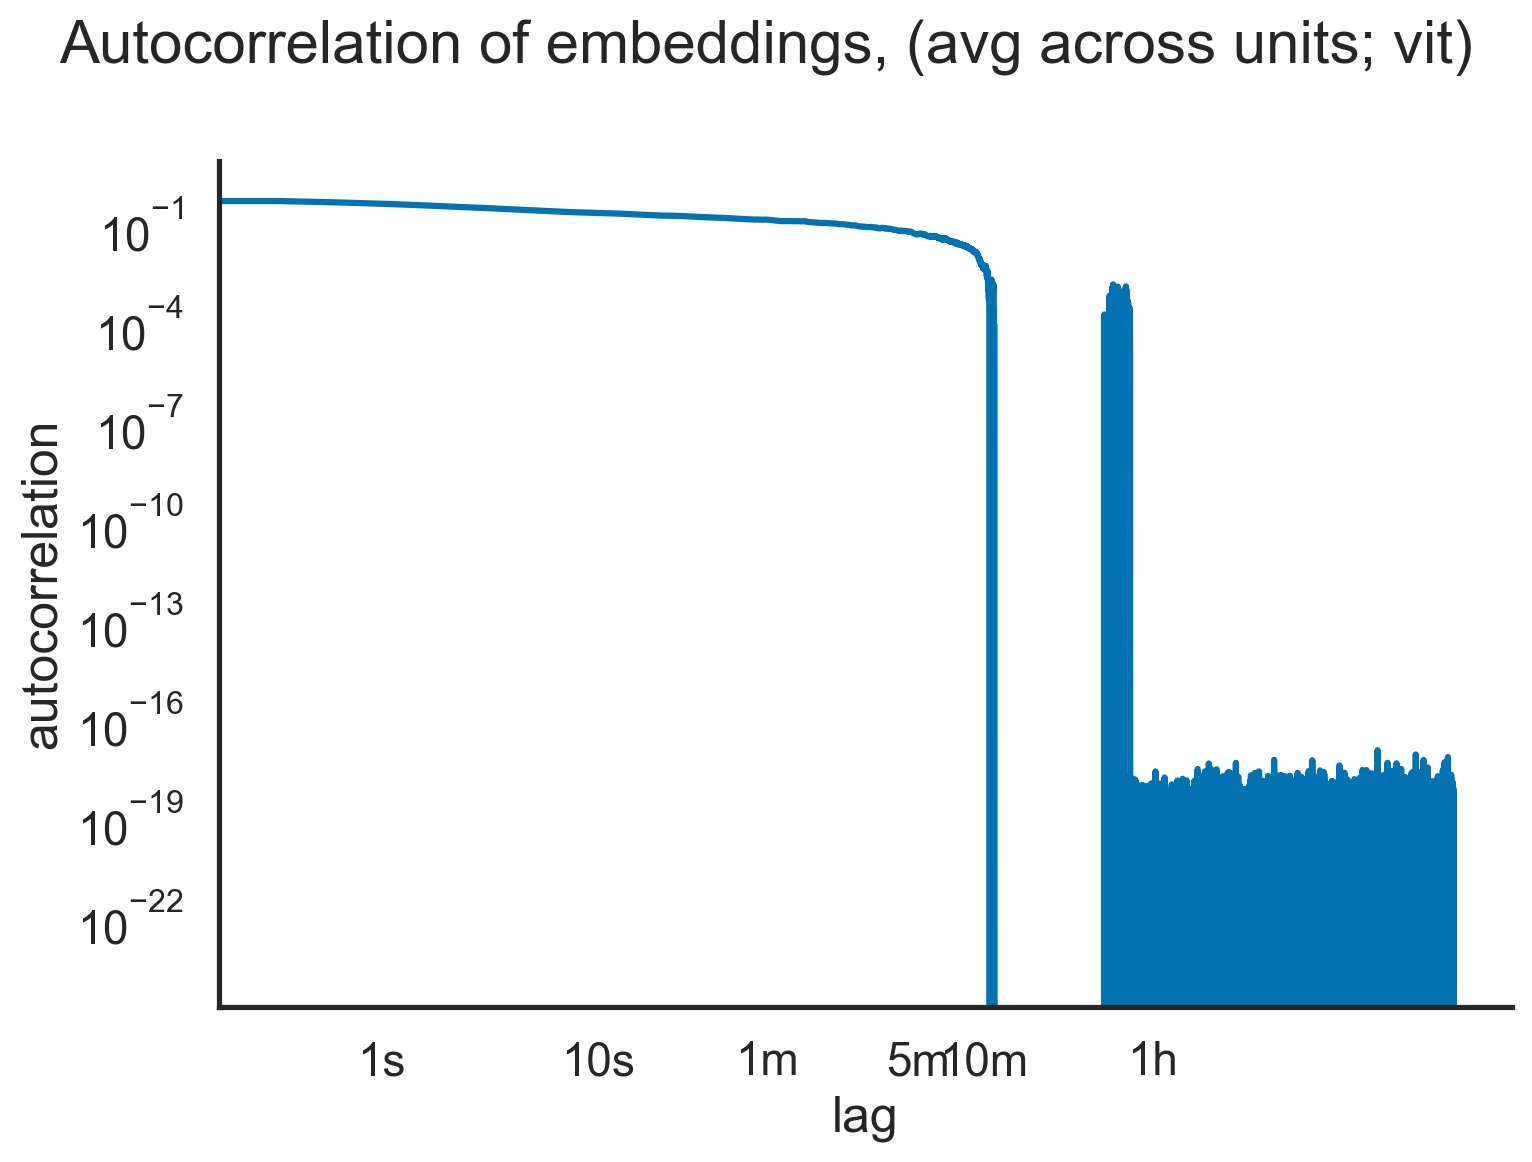

In [ ]:
acfs_all, _ = run_plot_acf(all_embeddings, permute_n_iter=0, n_jobs=N_JOBS, plot=True,
                           save_folder=OUTPUT_DIR, save_tag=MODEL_NAME)

# default: n = embeddings.shape[0], nlags = n // 2 
# change? to n = 50000, nlags = 20000 

## Calculate pairwise distances 

In [ ]:
# Load embeddings if not already loaded
embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*{MODEL_NAME}*.pkl'))
all_dicts = [pickle_load_dict(e) for e in embeddings_paths]
all_embeddings, _ = concatenate_embeddings_timestamps([d['embeddings'] for d in all_dicts], 
                                                      [d['timestamps'] for d in all_dicts],
                                                      downsampled_frame_rate=DOWNSAMPLED_FR)


100%|██████████| 1/1 [00:13<00:00, 13.72s/it]


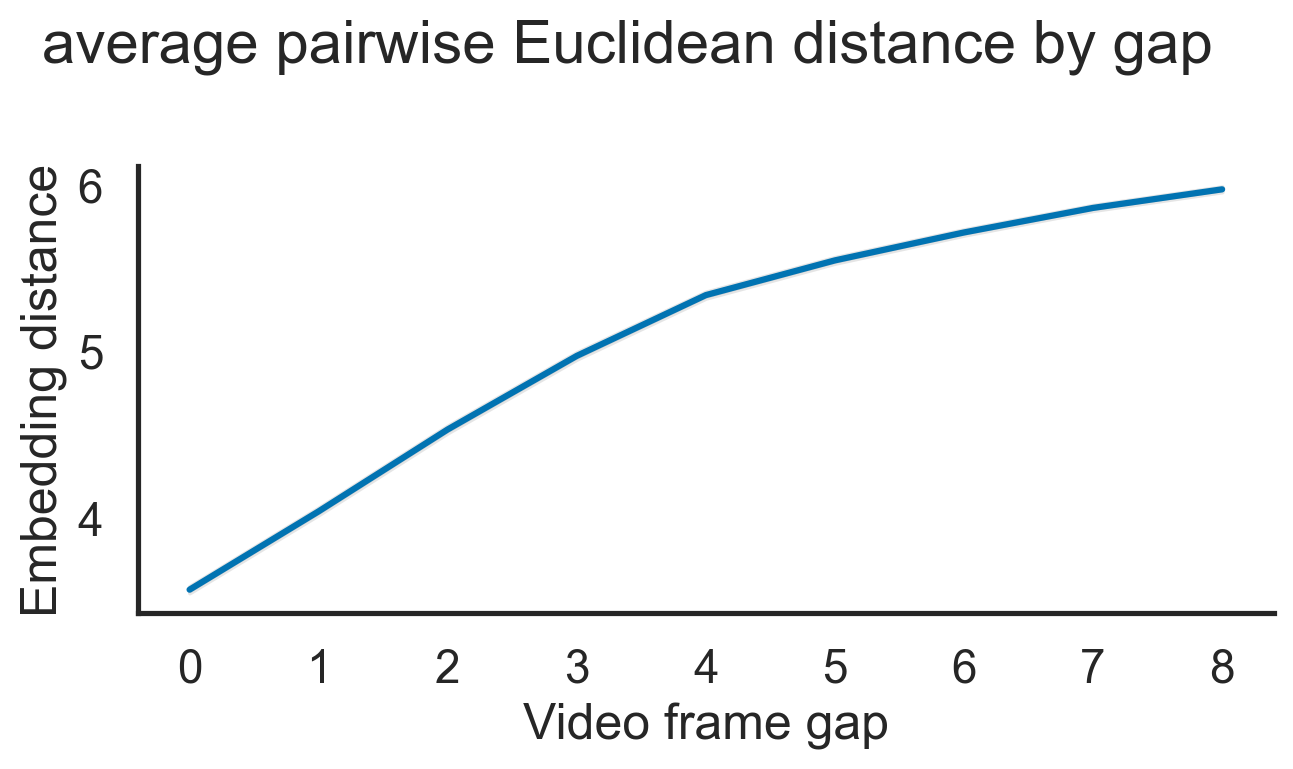

In [69]:
consec_dist = get_consec_dists(all_embeddings, plot=True, save_folder=OUTPUT_DIR, save_tag=MODEL_NAME)

## Familiarity/novelty autocorrelation

now, we will choose a threshold to define familiar vs. novel events (frame embeddings). We will choose a radius (based on the results above of pairwise distances) and take the union of circles around the datapoints to get the "familiarity ball". We will do this ignoring the last <gap> events (WM). Then, events will be marked as either familiar or novel based on their presence in that region.

Finally, we'll compute autocorrelation of that binary vector.

In [3]:
# Load embeddings if not already loaded
embeddings_paths = sorted(glob.glob(OUTPUT_DIR + f'/video_embeddings/*{MODEL_NAME}*.pkl'))
all_dicts = [pickle_load_dict(e) for e in embeddings_paths]
all_embeddings, _ = concatenate_embeddings_timestamps([d['embeddings'] for d in all_dicts], 
                                                      [d['timestamps'] for d in all_dicts],
                                                      downsampled_frame_rate=DOWNSAMPLED_FR)

# load consec_dists if not already loaded
consec_dist = pickle_load_dict(OUTPUT_DIR + f'/consec_dist/consec_dist-{MODEL_NAME}.pkl')

In [ ]:
# testing
gap = 8
familiarity_ts = get_familiarity_timeseries(all_embeddings, consec_dist, gap, n_jobs=N_JOBS)

In [ ]:
# testing
_ = run_plot_acf(familiarity_ts,  n=None, nlags=None, permute_n_iter=0, n_jobs=N_JOBS, 
                     plot=True, save_folder=OUTPUT_DIR, save_tag = f'{MODEL_NAME}-gap{gap}')

Computing autocorrelation of familiarity timeseries...


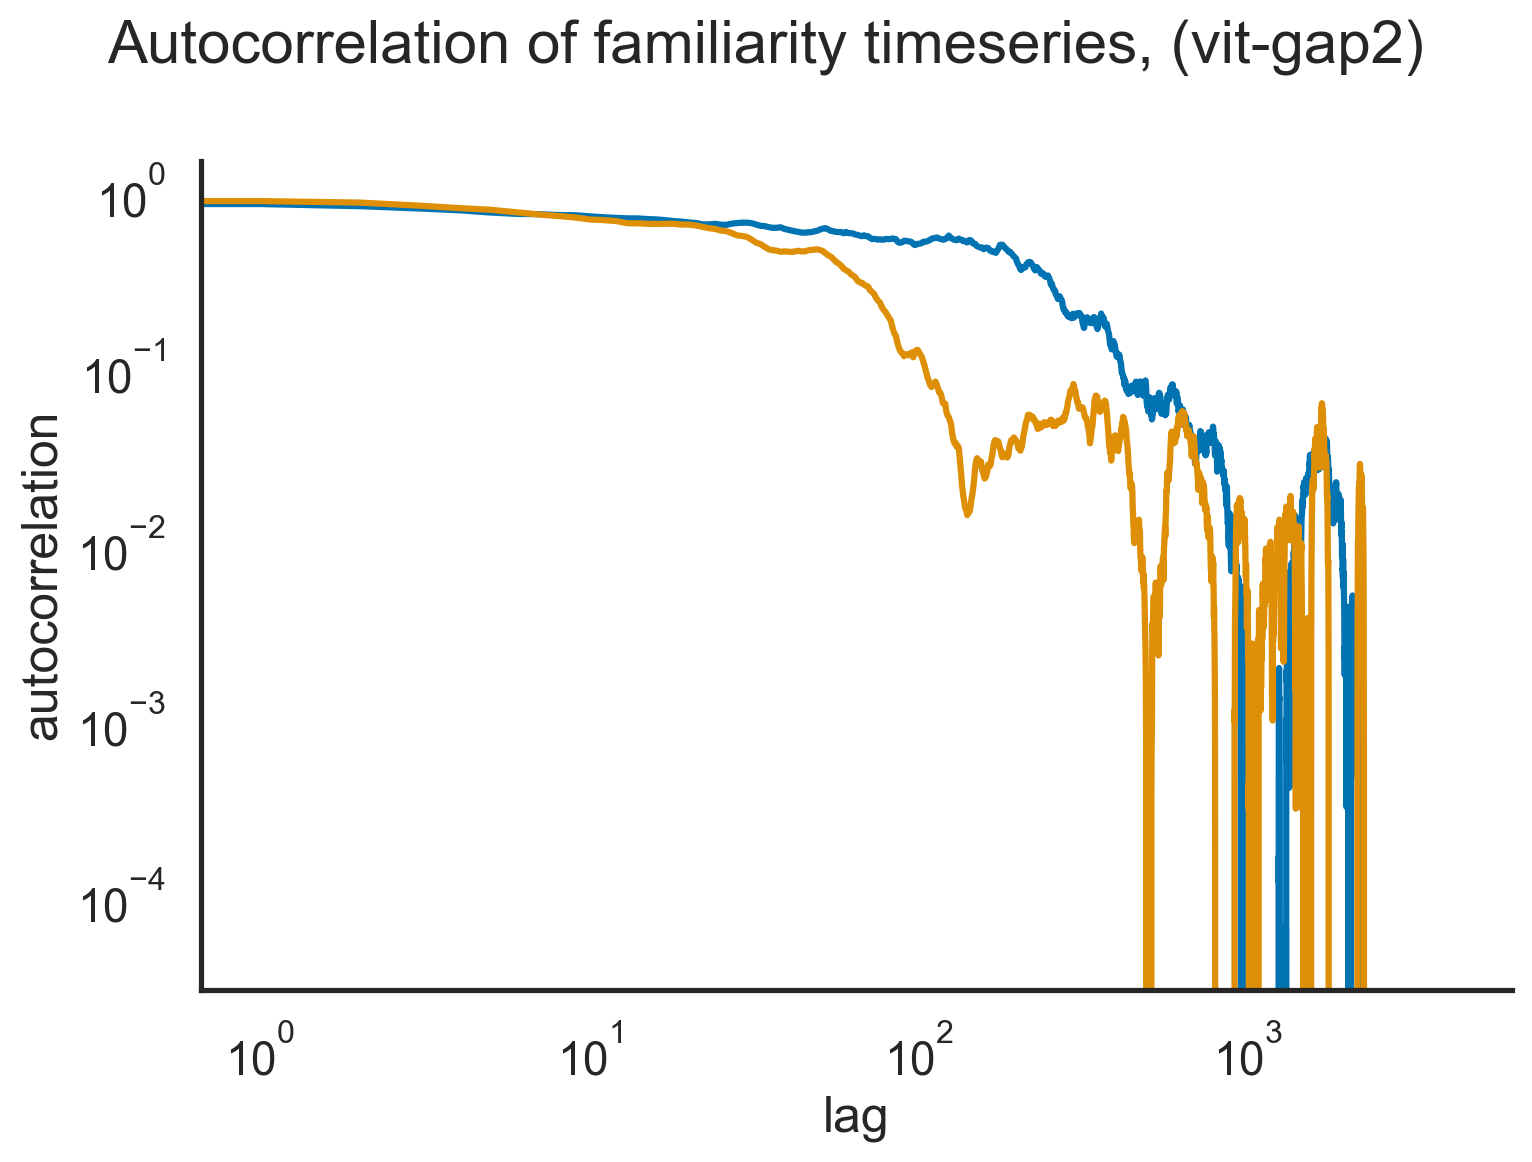

Computing autocorrelation of familiarity timeseries...


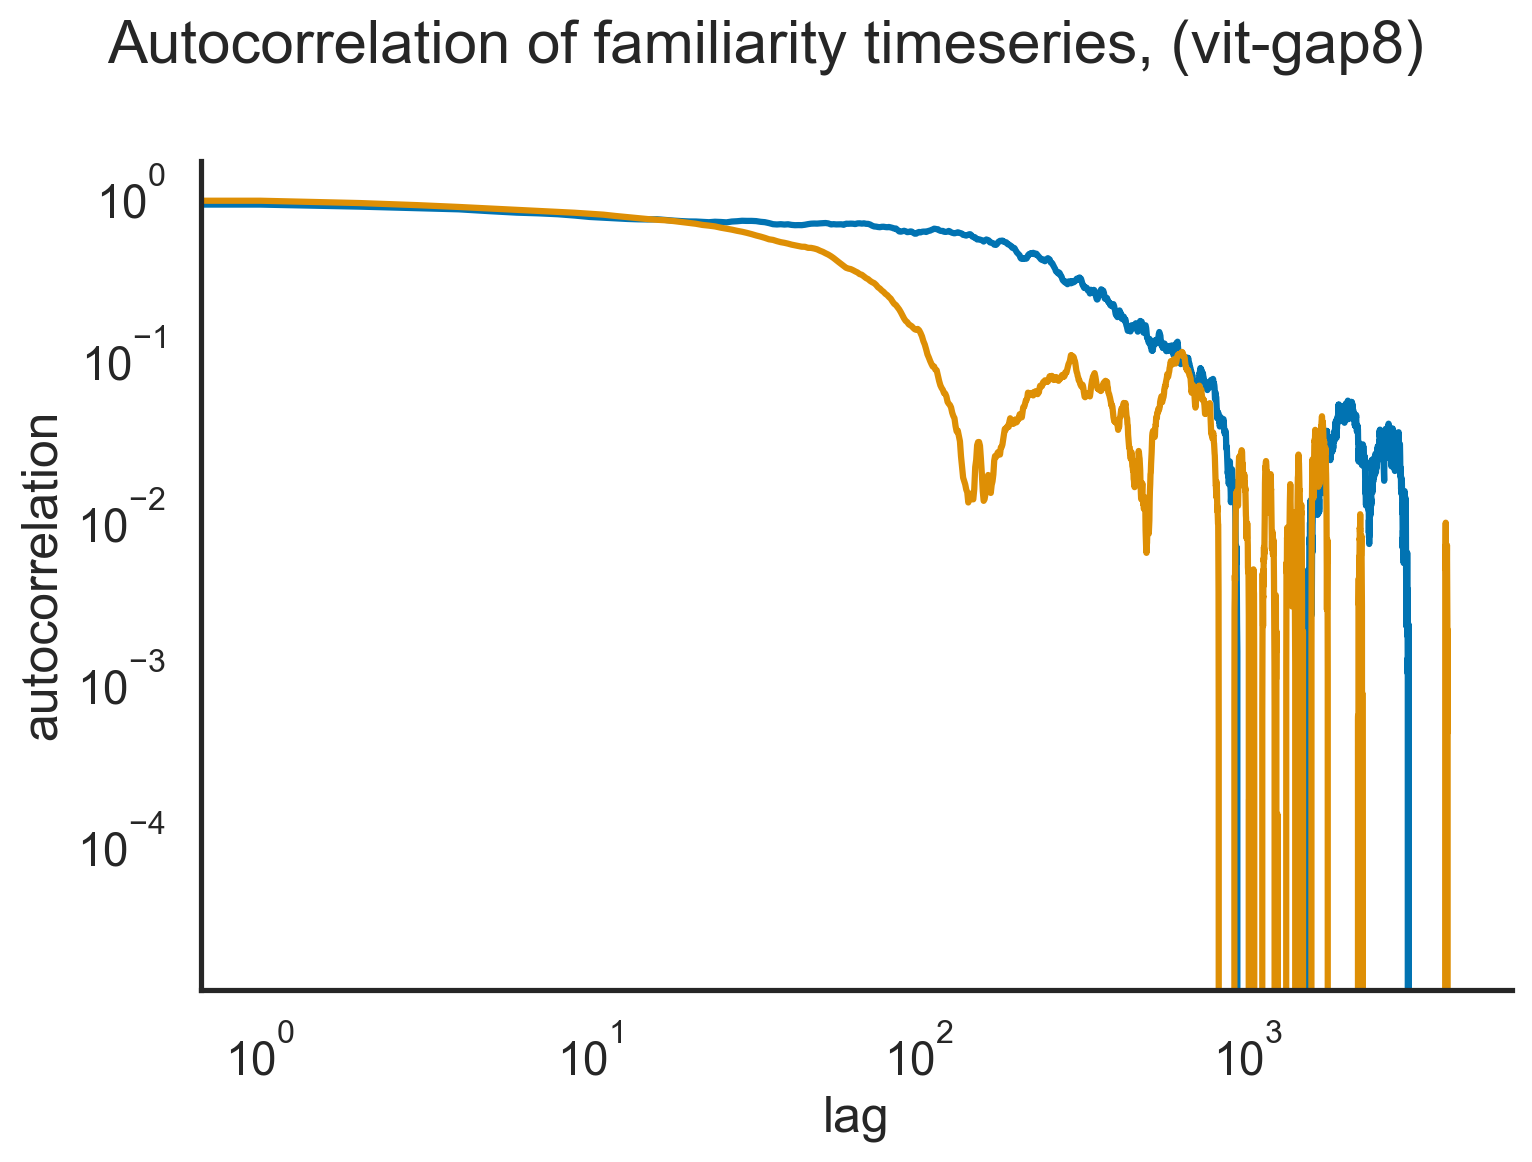

Computing autocorrelation of familiarity timeseries...


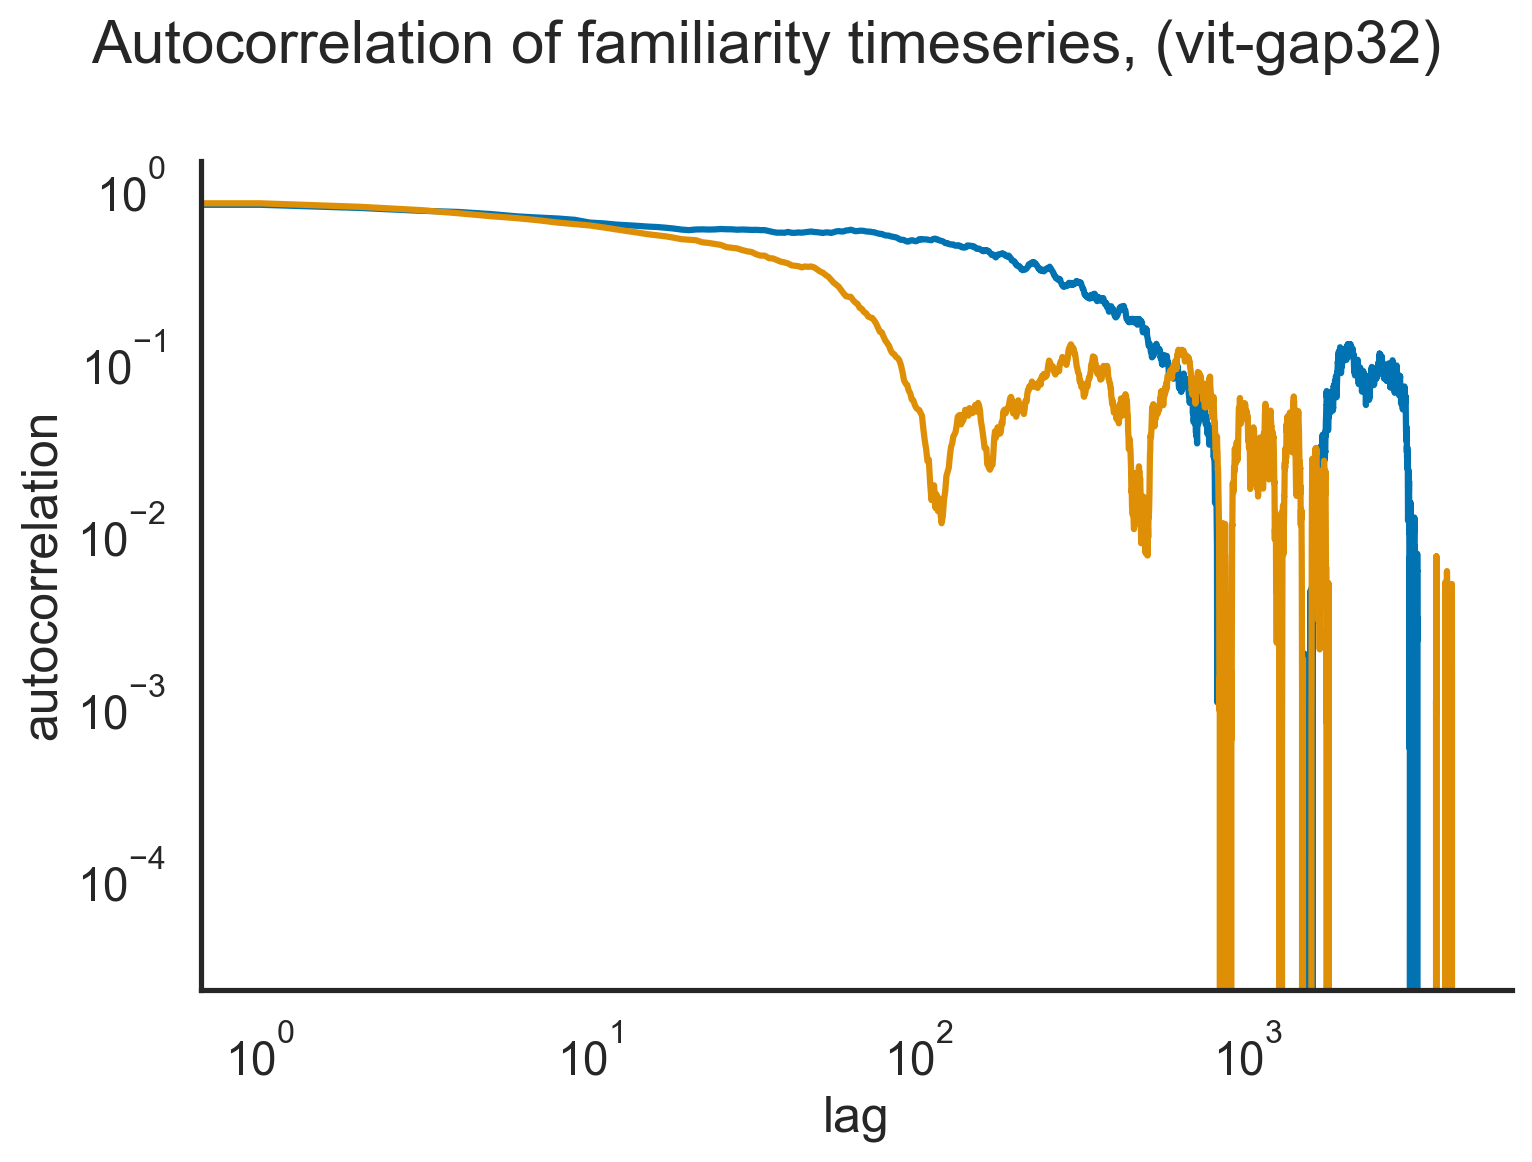

Computing autocorrelation of familiarity timeseries...


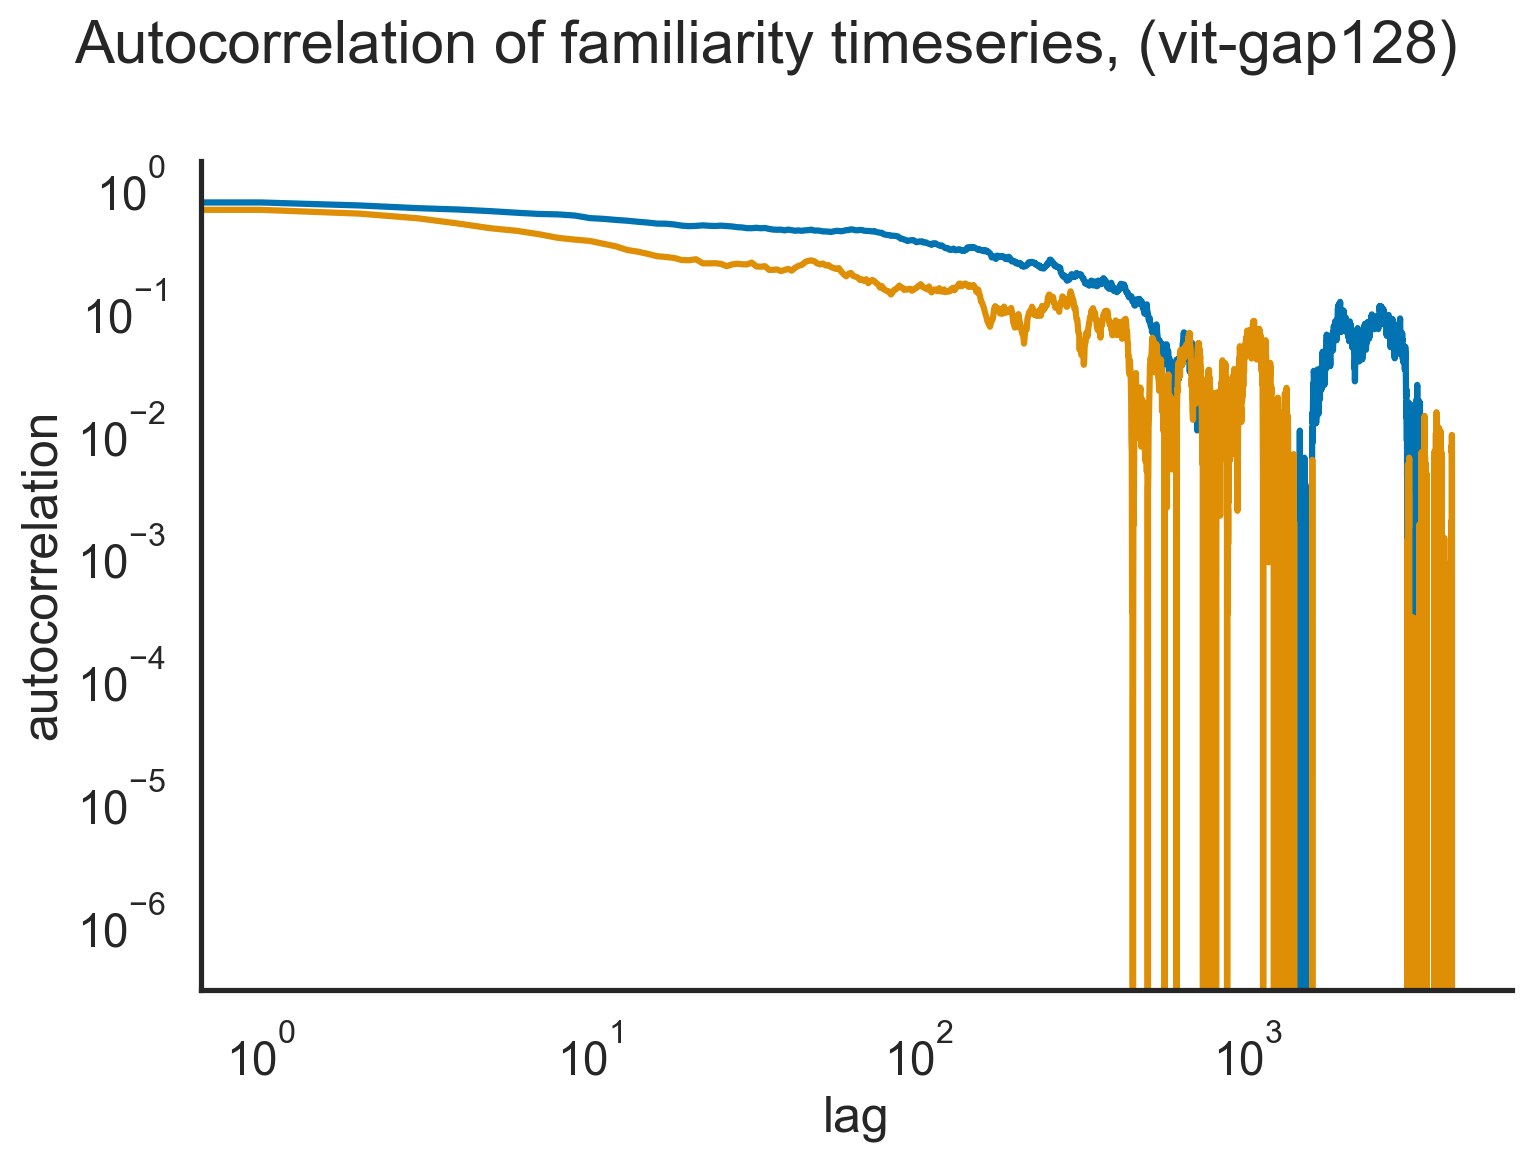

In [7]:
for gap in [2, 8, 32, 128]:
    familiarity_ts = get_familiarity_timeseries(all_embeddings, consec_dist, gap, n_jobs=N_JOBS)
    _ = run_plot_acf(familiarity_ts,  n=None, nlags=None, permute_n_iter=0, n_jobs=N_JOBS, 
                     plot=True, save_folder=OUTPUT_DIR, save_tag = f'{MODEL_NAME}-gap{gap}')

In [ ]:
# def apply_pca(X, n_components=None):
#     pca = PCA(n_components=n_components)
#     X_pca = pca.fit_transform(X)
#     explained_variance_ratio = pca.explained_variance_ratio_
#     return X_pca, explained_variance_ratio, pca

# n_components = dim  # Number of principal components to keep
# X_pca, explained_variance_ratio, pca_model = apply_pca(embeddings, n_components)

# f, ax = plt.subplots(1,1, figsize=(5,4))
# ax.plot(np.cumsum(explained_variance_ratio))
# ax.set_xlabel('# PCs')
# ax.set_ylabel('cum. var. explaiend')
# sns.despine()
# f.tight_layout()
# f, ax = plt.subplots(1,1, figsize=(5,4))
# # ax.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
# ax.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(n), cmap='viridis')
# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# sns.despine()
# f.tight_layout()